In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
''' from google.colab import files
uploaded = files.upload() '''

' from google.colab import files\nuploaded = files.upload() '

In [3]:
''' !unzip -uq "/content/ResizeDataset.zip" -d "/content" '''

' !unzip -uq "/content/ResizeDataset.zip" -d "/content" '

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


Chargement des données : 




In [5]:
train_dir='/content/drive/MyDrive/Dataset'

In [6]:
Labels = ['Benign', 'Malignant','Sain']

In [7]:
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i]) 

class : 
0 Benign
1 Malignant
2 Sain


In [8]:
print('Number of classes:',len(Labels))

Number of classes: 3


**Transfert d'apprentissage avec le hub TensorFlow :**





In [9]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

In [10]:
IMAGE_SIZE

(224, 224)

Dans notre situation, nous allons prétraiter nos images en convertissant les valeurs de pixel dans la plage [0, 1] (toutes les valeurs sont maintenant dans la plage [0, 255]). Les données d'entrée doivent être mises à l'échelle à 224 × 224 pixels en tant qu'entrée, comme spécifié par les réseaux. Vous pouvez choisir d'utiliser ou non l'augmentation d'image.

In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 42 images belonging to 3 classes.
Found 28 images belonging to 3 classes.


Construisez le modèle :

In [12]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE]  )


In [13]:
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [14]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 2,915,395
Trainable params: 657,411
Non-trainable params: 2,257,984
___________________

Modèle de formation :

Validez chaque étape en entraînant le modèle avec l'ensemble de données de validation. Nous atteignons une précision de 81 % après 15 époques, mais un réglage fin peut augmenter cette précision

In [15]:
LEARNING_RATE = 0.001 
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [16]:
EPOCHS=15
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/15
2/2 [==============================] - 40s 20s/step - loss: 1.4310 - accuracy: 0.4062 - val_loss: 1.2873 - val_accuracy: 0.4375
Epoch 2/15
2/2 [==============================] - 1s 783ms/step - loss: 0.3977 - accuracy: 0.8750 - val_loss: 1.5357 - val_accuracy: 0.6250
Epoch 3/15
2/2 [==============================] - 1s 780ms/step - loss: 0.5023 - accuracy: 0.7812 - val_loss: 0.8688 - val_accuracy: 0.6875
Epoch 4/15
2/2 [==============================] - 1s 794ms/step - loss: 0.0966 - accuracy: 0.9688 - val_loss: 0.7524 - val_accuracy: 0.6875
Epoch 5/15
2/2 [==============================] - 1s 987ms/step - loss: 0.1426 - accuracy: 0.9615 - val_loss: 1.4184 - val_accuracy: 0.6875
Epoch 6/15
2/2 [==============================] - 1s 827ms/step - loss: 0.4528 - accuracy: 0.7500 - val_loss: 0.7644 - val_accuracy: 0.6875
Epoch 7/15
2/2 [==============================] - 1s 725ms/step - loss: 0.0247 - accuracy: 1.0000 - val_loss: 1.4284 - val_accuracy: 0.6875
Epoch 8/15
2/2 [=====

Vérification des performances :
formation et validation des tracés, précision et perte

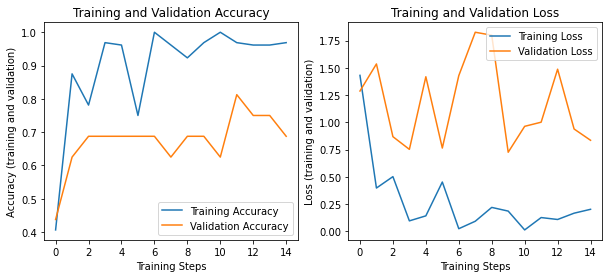

In [17]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

1/1 [==============================] - 1s 724ms/step
class: Benign, confidence: 0.999923


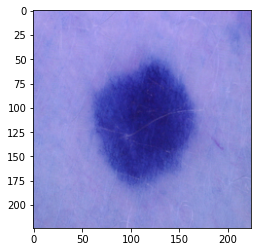

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 22ms/step
class: Sain, confidence: 0.975623


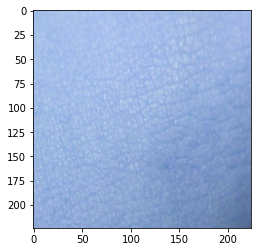

1/1 [==============================] - 0s 20ms/step
class: Sain, confidence: 0.975623


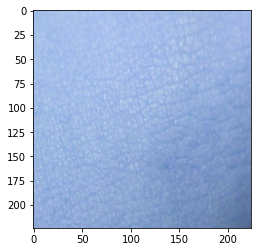

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 21ms/step
class: Sain, confidence: 0.975623


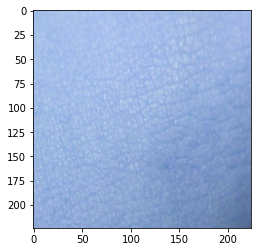

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 21ms/step
class: Malignant, confidence: 0.855015


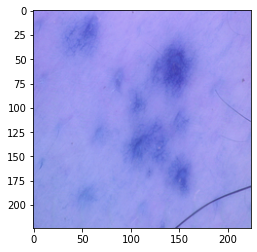

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 23ms/step
class: Malignant, confidence: 0.709626


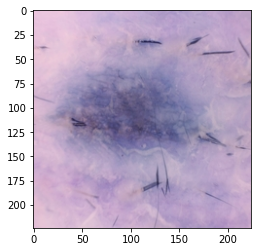

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 33ms/step
class: Sain, confidence: 0.975623


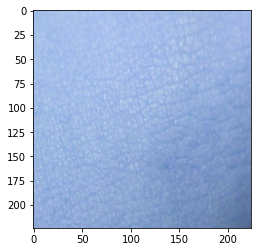

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 29ms/step
class: Malignant, confidence: 0.702225


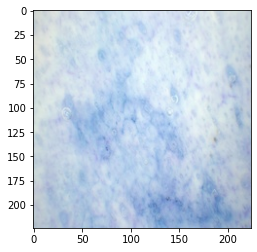

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 24ms/step
class: Sain, confidence: 0.975623


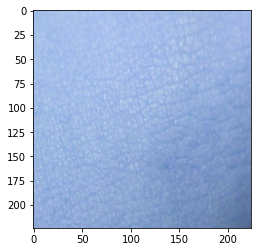

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 20ms/step
class: Benign, confidence: 0.910993


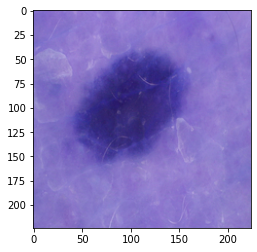

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 28ms/step
class: Benign, confidence: 0.933561


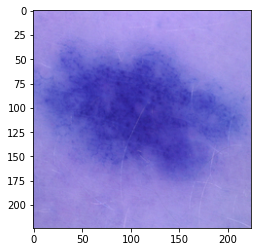

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 23ms/step
class: Benign, confidence: 0.975882


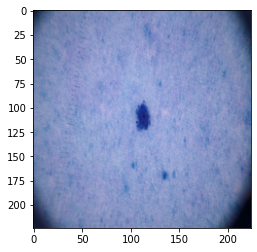

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 21ms/step
class: Benign, confidence: 0.577220


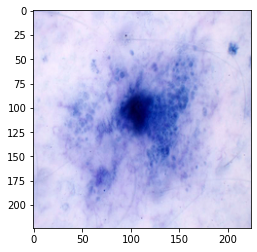

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 29ms/step
class: Sain, confidence: 0.975623


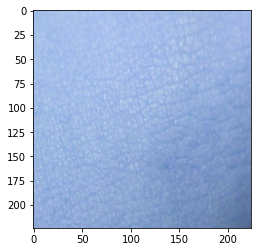

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 34ms/step
class: Sain, confidence: 0.975623


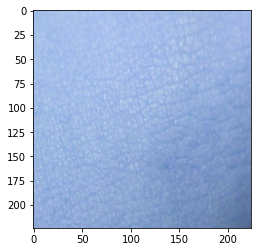

<Figure size 432x288 with 0 Axes>

1/1 [==============================] - 0s 27ms/step
class: Malignant, confidence: 0.836588


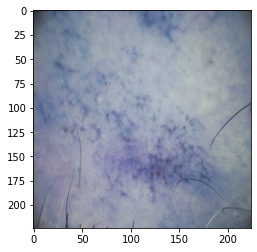

<Figure size 432x288 with 0 Axes>

In [18]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    
    return {Labels[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    
    
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

2/2 [==============================] - 1s 597ms/step
Classification Report
              precision    recall  f1-score   support

      benign       0.70      0.88      0.78         8
   malignant       0.83      0.62      0.71         8
        sain       1.00      1.00      1.00        12

    accuracy                           0.86        28
   macro avg       0.84      0.83      0.83        28
weighted avg       0.87      0.86      0.85        28

2/2 [==============================] - 0s 221ms/step - loss: 0.6069 - accuracy: 0.7857
[0.6068562865257263, 0.7857142686843872]


Confusion Matrix


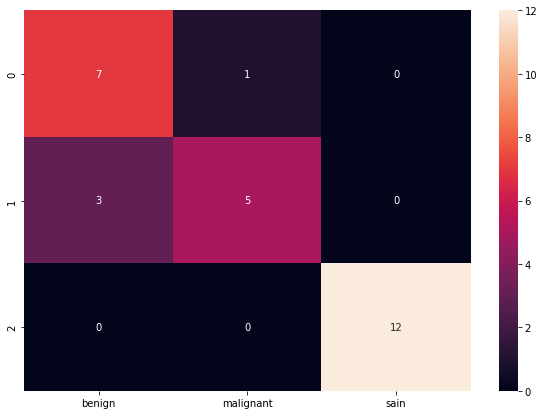

In [20]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

In [21]:
cd /content/drive/MyDrive/Buffml/code

[Errno 2] No such file or directory: '/content/drive/MyDrive/Buffml/code'
/content


#Export as saved model and convert to TFLite

In [22]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)

export_path

'/tmp/saved_models/1670927786'

In [23]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [24]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {Labels[class_idx]: probabilities[class_idx]}

SOURCE: class: benign, file: benign/21.jpg
1/1 [==============================] - 0s 382ms/step
PREDICTED: class: Benign, confidence: 0.933561


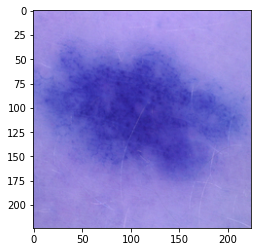

<Figure size 432x288 with 0 Axes>

SOURCE: class: malignant, file: malignant/16.jpg
1/1 [==============================] - 0s 24ms/step
PREDICTED: class: Malignant, confidence: 0.997625


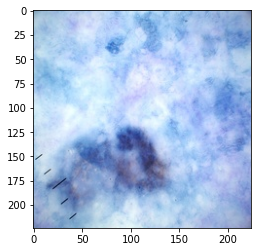

In [25]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [26]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

11555872